## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler

from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
import scipy.sparse as sp
from numba import jit
import squidpy as sq
import models
from sklearn.metrics import accuracy_score
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
adata = sq.datasets.visium_fluo_adata()#datasets.visium_fluo_adata_crop([path])


sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 2800 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

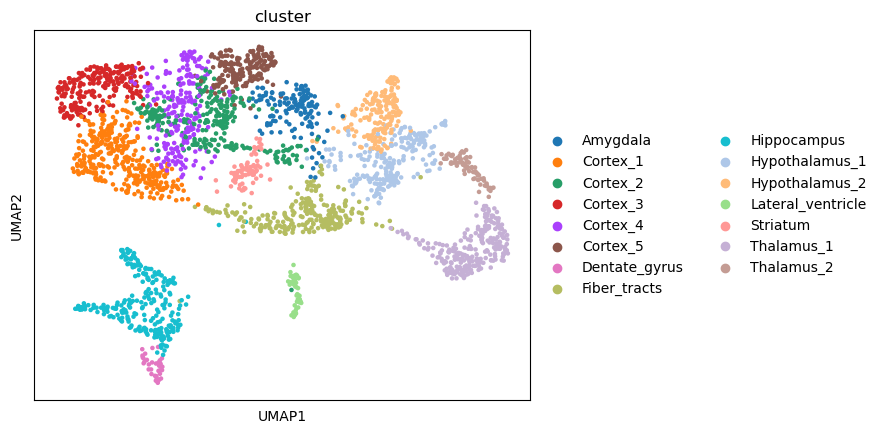

In [3]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='cluster')

In [4]:
for i in adata.obs['cluster'].unique():
    print(i)

Thalamus_2
Fiber_tracts
Cortex_2
Hypothalamus_2
Cortex_3
Cortex_4
Hypothalamus_1
Thalamus_1
Cortex_5
Amygdala
Cortex_1
Striatum
Hippocampus
Lateral_ventricle
Dentate_gyrus


In [5]:
import numpy as np

# Define a dictionary to map each cluster to its corresponding cell type
cell_type_mapping = {
    'Cortex_1': 'Cortex',
    'Cortex_2': 'Cortex',
    'Cortex_3': 'Cortex',
    'Cortex_4': 'Cortex',
    'Cortex_5': 'Cortex',
    'Amygdala': 'Amygdala',
    'Thalamus_1': 'Thalamus',
    'Thalamus_2': 'Thalamus',
    'Striatum': 'Striatum',
    'Lateral_ventricle': 'Lateral_ventricle',
    'Hypothalamus_1': 'Hypothalamus',
    'Hypothalamus_2': 'Hypothalamus',
    'Fiber_tracts': 'Fiber_tracts',
    'Hippocampus': 'Hippocampus',
    'Dentate_gyrus': 'Dentate_gyrus'
}

# Create an empty list to store the updated cell types
cell_type_list = []

# Iterate over each cluster and assign the corresponding cell type
for i in range(adata.n_obs):
    cluster_name = adata.obs['cluster'][i]
    if cluster_name in cell_type_mapping:
        cell_type_list.append(cell_type_mapping[cluster_name])
    else:
        cell_type_list.append(cluster_name)

# Update the cell type column in the AnnData object
adata.obs['CellType'] = np.array(cell_type_list)


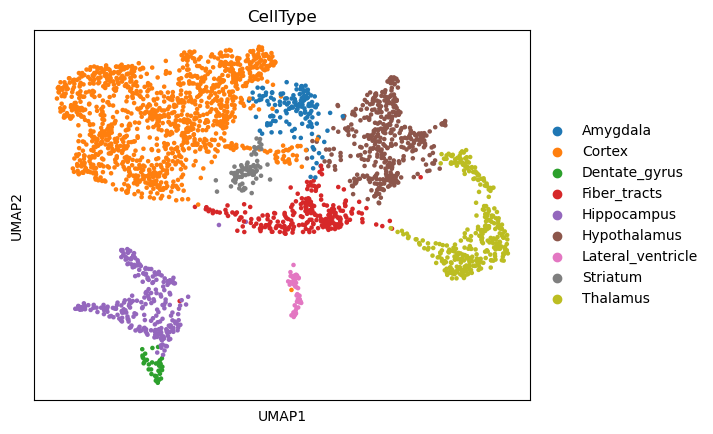

In [6]:
sc.pl.umap(adata, color='CellType')

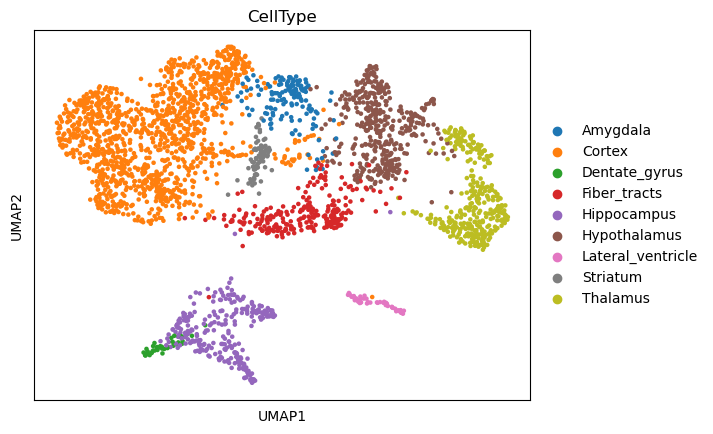

In [7]:
sc.pp.filter_genes_dispersion(adata,n_top_genes=3000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='CellType')

In [8]:
import random
import pandas as pd

def modify_labels(orig_labeles, probability=0.1):
    # Get the list of all possible labels
    all_labels = list(set(orig_labeles))

    # Create a list to store the modified labels
    modified_labels = []

    # Loop over the labels in the dataset
    for label in orig_labeles:
        # Generate a random number between 0 and 1
        r = random.random()

        # If the random number is smaller than the probability,
        # modify the label by choosing a random label from the list of all labels,
        # excluding the original label
        if r < probability:
            modified_label = random.choice([l for l in all_labels if l != label])
        else:
            modified_label = label

        # Add the modified label to the list
        modified_labels.append(modified_label)

    # Create a DataFrame with the original and modified labels
    df = pd.DataFrame({"label": orig_labeles, "modified_label": modified_labels})


    return df , (np.where(df["label"] != df["modified_label"]))

def one_hot_encode(labels):
    """
    One-hot encodes an array of labels.
    
    Args:
        labels (numpy.ndarray): Array of labels.
        
    Returns:
        tuple: One-hot encoded array of labels, and a label encoder.
    """
    values = np.array(labels)
    print(values)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(integer_encoded)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # invert first example
    inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
    return onehot_encoded, label_encoder



In [9]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier


def multi_ada_sampling(data, label, classifier="svm", percent=1, L=10, prob_output=False, balance=True, iter=3):
    def update_xy(vote_class, label, percent, balance):
        sample_size = int(np.round(np.median(list(Counter(label).values()))))
        idx = []
        if balance:
            idx = resample(np.arange(len(vote_class)), n_samples=int(len(vote_class) * percent), replace=True, stratify=vote_class)
        else:
            if len(vote_class) > sample_size:
                idx = resample(np.arange(len(vote_class)), n_samples=int(sample_size * percent), replace=True, stratify=vote_class)
            else:
                idx = resample(np.arange(len(vote_class)), n_samples=int(len(vote_class) * percent), replace=True, stratify=vote_class)
        
        return data[:, idx], label[idx]

    models = []
    for _ in range(L):
        X = data
        Y = label
        model_list = []
        prob_list = []
        
        for _ in range(iter):
            if classifier == "rf":
                model = RandomForestClassifier(n_estimators=100)
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
            elif classifier == "svm":
                model = SVC(probability=True)
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
            elif classifier =="knn":
                model = KNeighborsClassifier()
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
                #print(prob)
            else:
                raise ValueError(f"Unknown classifier: {classifier}")
            
            X, Y = [], []
            xy_update = []
            for j in range(prob.shape[1]):
                vote_class = prob[label == j]
                xy_update.append(update_xy(vote_class, label, percent, balance))
            
            cur_X = np.column_stack([xy[0] for xy in xy_update])
            cur_Y = np.concatenate([xy[1] for xy in xy_update])
            X, Y = cur_X, cur_Y
        models.append(model)
    
    predict_mat = np.zeros((data.shape[1], len(np.unique(label))))
    final = []
    for model in models:
        if classifier == "svm":
            tmp = model.predict_proba(data.T)[:, list(np.unique(label))]
        else:
            tmp = model.predict_proba(data.T)[:, list(np.unique(label))]
        predict_mat += tmp
    
    if prob_output:
        final = np.max(predict_mat, axis=1)
        final = dict(zip(list(np.unique(label))[np.argmax(predict_mat, axis=1)], final))
    else:
        final = 0#list(np.unique(label))[np.argmax(predict_mat, axis=1)]
    
    return {"final": final, "models": models, "prob": predict_mat}

def get_conf_from_scReClassify(adata, res , formerlabels, L=10):
    prob_mat= res['prob']
    return prob_mat[np.arange(len(prob_mat)), formerlabels]/L



In [10]:
adata_copy = adata.copy()


In [11]:
from sklearn.preprocessing import LabelEncoder
epoch_num=20



from sklearn.preprocessing import LabelEncoder
screc_res_list_rf = []
screc_res_list_svm = []
screc_res_list_knn = []
cell_anno_list = []
screc_res_list_rf_var = []
screc_res_list_knn_var = []
screc_res_list_svm_var = []
cell_anno_list_var = []
for i in range(1,6):
    tmp_roc_screc_rf = []
    tmp_roc_screc_knn = []
    tmp_roc_screc_svm = []
    tmp_roc_cell_anno = []
    for j in range(10):
        adata= adata_copy.copy()
        #sc.pp.subsample(adata, n_obs=10000)
        labeles = adata.obs['CellType']
        df , were_changed = modify_labels(labeles , probability=0.1*i)
        were_changed_array =np.zeros(adata.n_obs)
        were_changed_array[were_changed]=1
        adata.obs['former_labels']=df['label']
        adata.obs['new_labels']=df['modified_label']
        adata.obs['new_labels']
        le = LabelEncoder()
        le.fit(adata.obs['new_labels'])

        mod_labels= le.transform(adata.obs['new_labels'])
        former_labels= le.transform(adata.obs['former_labels'])
        
        res = multi_ada_sampling(adata.obsm['X_pca'].T,mod_labels, classifier="knn")
        conf = get_conf_from_scReClassify(adata,res,mod_labels)
        tmp_roc_screc_knn.append(roc_auc_score(1-were_changed_array, conf))

        res = multi_ada_sampling(adata.obsm['X_pca'].T,mod_labels, classifier="rf")
        conf = get_conf_from_scReClassify(adata,res,mod_labels)
        tmp_roc_screc_rf.append(roc_auc_score(1-were_changed_array, conf))
        res = multi_ada_sampling(adata.obsm['X_pca'].T,mod_labels, classifier="svm")
        conf = get_conf_from_scReClassify(adata,res,mod_labels)
        tmp_roc_screc_svm.append(roc_auc_score(1-were_changed_array, conf))
        prob_list = models.follow_training_dyn_neural_net(adata, label_key='new_labels',iterNum=epoch_num, device=device, batch_size=64)
        all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)
        tmp_roc_cell_anno.append(roc_auc_score(1-were_changed_array, all_conf))
        print(tmp_roc_screc_knn)
        print(tmp_roc_screc_rf)
        print(tmp_roc_screc_svm)
        print(tmp_roc_cell_anno)
    screc_res_list_knn.append(np.mean(tmp_roc_screc_knn))
    screc_res_list_rf.append(np.mean(tmp_roc_screc_rf))
    screc_res_list_svm.append(np.mean(tmp_roc_screc_svm))
    cell_anno_list.append(np.mean(tmp_roc_cell_anno))
    screc_res_list_rf_var.append(np.var(tmp_roc_screc_rf))
    screc_res_list_svm_var.append(np.var(tmp_roc_screc_svm))
    cell_anno_list_var.append(np.var(tmp_roc_cell_anno))
    screc_res_list_knn_var.append(np.var(tmp_roc_screc_knn))



/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.194
[1,    22] loss: 2.181
[1,    32] loss: 2.167
[1,    42] loss: 2.152
[2,     2] loss: 0.430
[2,    12] loss: 2.126
[2,    22] loss: 2.112
[2,    32] loss: 2.083
[2,    42] loss: 2.068
[3,     2] loss: 0.412
[3,    12] loss: 2.040
[3,    22] loss: 2.003
[3,    32] loss: 2.003
[3,    42] loss: 1.936
[4,     2] loss: 0.384
[4,    12] loss: 1.896
[4,    22] loss: 1.864
[4,    32] loss: 1.803
[4,    42] loss: 1.792
[5,     2] loss: 0.342
[5,    12] loss: 1.726
[5,    22] loss: 1.690
[5,    32] loss: 1.649
[5,    42] loss: 1.635
[6,     2] loss: 0.325
[6,    12] loss: 1.544
[6,    22] loss: 1.509
[6,    32] loss: 1.473
[6,    42] loss: 1.482
[7,     2] loss: 0.296
[7,    12] loss: 1.414
[7,    22] loss: 1.337
[7,    32] loss: 1.361
[7,    42] loss: 1.379
[8,     2] loss: 0.247
[8,    12] loss: 1.256
[8,    22] loss: 1.200
[8,    32] loss: 1.332
[8,    42] loss: 1.219
[9,     2] loss: 0.262
[9,    12] loss: 1.190
[9,    22] loss: 1.188
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.199
[1,    22] loss: 2.184
[1,    32] loss: 2.171
[1,    42] loss: 2.156
[2,     2] loss: 0.428
[2,    12] loss: 2.130
[2,    22] loss: 2.108
[2,    32] loss: 2.088
[2,    42] loss: 2.074
[3,     2] loss: 0.410
[3,    12] loss: 2.043
[3,    22] loss: 2.005
[3,    32] loss: 1.985
[3,    42] loss: 1.936
[4,     2] loss: 0.383
[4,    12] loss: 1.886
[4,    22] loss: 1.840
[4,    32] loss: 1.813
[4,    42] loss: 1.785
[5,     2] loss: 0.339
[5,    12] loss: 1.712
[5,    22] loss: 1.655
[5,    32] loss: 1.630
[5,    42] loss: 1.601
[6,     2] loss: 0.297
[6,    12] loss: 1.479
[6,    22] loss: 1.462
[6,    32] loss: 1.394
[6,    42] loss: 1.454
[7,     2] loss: 0.279
[7,    12] loss: 1.378
[7,    22] loss: 1.338
[7,    32] loss: 1.305
[7,    42] loss: 1.232
[8,     2] loss: 0.250
[8,    12] loss: 1.267
[8,    22] loss: 1.211
[8,    32] loss: 1.109
[8,    42] loss: 1.192
[9,     2] loss: 0.232
[9,    12] loss: 1.146
[9,    22] loss: 1.146
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.198
[1,    22] loss: 2.189
[1,    32] loss: 2.170
[1,    42] loss: 2.160
[2,     2] loss: 0.428
[2,    12] loss: 2.137
[2,    22] loss: 2.118
[2,    32] loss: 2.094
[2,    42] loss: 2.077
[3,     2] loss: 0.413
[3,    12] loss: 2.048
[3,    22] loss: 2.030
[3,    32] loss: 1.995
[3,    42] loss: 1.968
[4,     2] loss: 0.387
[4,    12] loss: 1.937
[4,    22] loss: 1.886
[4,    32] loss: 1.839
[4,    42] loss: 1.808
[5,     2] loss: 0.353
[5,    12] loss: 1.752
[5,    22] loss: 1.714
[5,    32] loss: 1.658
[5,    42] loss: 1.574
[6,     2] loss: 0.322
[6,    12] loss: 1.573
[6,    22] loss: 1.516
[6,    32] loss: 1.473
[6,    42] loss: 1.493
[7,     2] loss: 0.289
[7,    12] loss: 1.368
[7,    22] loss: 1.434
[7,    32] loss: 1.370
[7,    42] loss: 1.313
[8,     2] loss: 0.264
[8,    12] loss: 1.288
[8,    22] loss: 1.292
[8,    32] loss: 1.273
[8,    42] loss: 1.300
[9,     2] loss: 0.276
[9,    12] loss: 1.190
[9,    22] loss: 1.178
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.438
[1,    12] loss: 2.192
[1,    22] loss: 2.178
[1,    32] loss: 2.168
[1,    42] loss: 2.156
[2,     2] loss: 0.428
[2,    12] loss: 2.134
[2,    22] loss: 2.113
[2,    32] loss: 2.094
[2,    42] loss: 2.077
[3,     2] loss: 0.417
[3,    12] loss: 2.043
[3,    22] loss: 2.019
[3,    32] loss: 1.991
[3,    42] loss: 1.979
[4,     2] loss: 0.381
[4,    12] loss: 1.912
[4,    22] loss: 1.882
[4,    32] loss: 1.831
[4,    42] loss: 1.815
[5,     2] loss: 0.355
[5,    12] loss: 1.751
[5,    22] loss: 1.694
[5,    32] loss: 1.650
[5,    42] loss: 1.679
[6,     2] loss: 0.309
[6,    12] loss: 1.528
[6,    22] loss: 1.494
[6,    32] loss: 1.498
[6,    42] loss: 1.458
[7,     2] loss: 0.278
[7,    12] loss: 1.375
[7,    22] loss: 1.402
[7,    32] loss: 1.368
[7,    42] loss: 1.407
[8,     2] loss: 0.257
[8,    12] loss: 1.327
[8,    22] loss: 1.255
[8,    32] loss: 1.317
[8,    42] loss: 1.268
[9,     2] loss: 0.240
[9,    12] loss: 1.200
[9,    22] loss: 1.170
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.199
[1,    22] loss: 2.186
[1,    32] loss: 2.171
[1,    42] loss: 2.159
[2,     2] loss: 0.430
[2,    12] loss: 2.135
[2,    22] loss: 2.117
[2,    32] loss: 2.103
[2,    42] loss: 2.079
[3,     2] loss: 0.415
[3,    12] loss: 2.049
[3,    22] loss: 2.027
[3,    32] loss: 1.996
[3,    42] loss: 1.961
[4,     2] loss: 0.391
[4,    12] loss: 1.919
[4,    22] loss: 1.892
[4,    32] loss: 1.847
[4,    42] loss: 1.841
[5,     2] loss: 0.361
[5,    12] loss: 1.749
[5,    22] loss: 1.678
[5,    32] loss: 1.603
[5,    42] loss: 1.633
[6,     2] loss: 0.303
[6,    12] loss: 1.547
[6,    22] loss: 1.457
[6,    32] loss: 1.454
[6,    42] loss: 1.431
[7,     2] loss: 0.269
[7,    12] loss: 1.342
[7,    22] loss: 1.328
[7,    32] loss: 1.302
[7,    42] loss: 1.235
[8,     2] loss: 0.251
[8,    12] loss: 1.255
[8,    22] loss: 1.311
[8,    32] loss: 1.197
[8,    42] loss: 1.222
[9,     2] loss: 0.228
[9,    12] loss: 1.170
[9,    22] loss: 1.206
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.201
[1,    22] loss: 2.193
[1,    32] loss: 2.178
[1,    42] loss: 2.168
[2,     2] loss: 0.431
[2,    12] loss: 2.146
[2,    22] loss: 2.128
[2,    32] loss: 2.114
[2,    42] loss: 2.094
[3,     2] loss: 0.419
[3,    12] loss: 2.071
[3,    22] loss: 2.036
[3,    32] loss: 2.019
[3,    42] loss: 1.996
[4,     2] loss: 0.394
[4,    12] loss: 1.959
[4,    22] loss: 1.927
[4,    32] loss: 1.885
[4,    42] loss: 1.853
[5,     2] loss: 0.363
[5,    12] loss: 1.775
[5,    22] loss: 1.770
[5,    32] loss: 1.694
[5,    42] loss: 1.655
[6,     2] loss: 0.321
[6,    12] loss: 1.619
[6,    22] loss: 1.558
[6,    32] loss: 1.523
[6,    42] loss: 1.481
[7,     2] loss: 0.285
[7,    12] loss: 1.432
[7,    22] loss: 1.431
[7,    32] loss: 1.412
[7,    42] loss: 1.373
[8,     2] loss: 0.252
[8,    12] loss: 1.331
[8,    22] loss: 1.322
[8,    32] loss: 1.277
[8,    42] loss: 1.240
[9,     2] loss: 0.242
[9,    12] loss: 1.222
[9,    22] loss: 1.252
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.191
[1,    22] loss: 2.183
[1,    32] loss: 2.169
[1,    42] loss: 2.148
[2,     2] loss: 0.428
[2,    12] loss: 2.128
[2,    22] loss: 2.107
[2,    32] loss: 2.091
[2,    42] loss: 2.066
[3,     2] loss: 0.407
[3,    12] loss: 2.038
[3,    22] loss: 2.007
[3,    32] loss: 1.988
[3,    42] loss: 1.944
[4,     2] loss: 0.384
[4,    12] loss: 1.893
[4,    22] loss: 1.879
[4,    32] loss: 1.831
[4,    42] loss: 1.776
[5,     2] loss: 0.349
[5,    12] loss: 1.694
[5,    22] loss: 1.685
[5,    32] loss: 1.657
[5,    42] loss: 1.594
[6,     2] loss: 0.315
[6,    12] loss: 1.576
[6,    22] loss: 1.546
[6,    32] loss: 1.440
[6,    42] loss: 1.412
[7,     2] loss: 0.278
[7,    12] loss: 1.400
[7,    22] loss: 1.347
[7,    32] loss: 1.369
[7,    42] loss: 1.279
[8,     2] loss: 0.262
[8,    12] loss: 1.223
[8,    22] loss: 1.262
[8,    32] loss: 1.231
[8,    42] loss: 1.214
[9,     2] loss: 0.224
[9,    12] loss: 1.185
[9,    22] loss: 1.153
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.196
[1,    22] loss: 2.191
[1,    32] loss: 2.176
[1,    42] loss: 2.157
[2,     2] loss: 0.430
[2,    12] loss: 2.134
[2,    22] loss: 2.122
[2,    32] loss: 2.107
[2,    42] loss: 2.089
[3,     2] loss: 0.412
[3,    12] loss: 2.061
[3,    22] loss: 2.025
[3,    32] loss: 1.999
[3,    42] loss: 1.989
[4,     2] loss: 0.382
[4,    12] loss: 1.916
[4,    22] loss: 1.910
[4,    32] loss: 1.866
[4,    42] loss: 1.814
[5,     2] loss: 0.358
[5,    12] loss: 1.766
[5,    22] loss: 1.763
[5,    32] loss: 1.684
[5,    42] loss: 1.657
[6,     2] loss: 0.320
[6,    12] loss: 1.601
[6,    22] loss: 1.556
[6,    32] loss: 1.538
[6,    42] loss: 1.494
[7,     2] loss: 0.275
[7,    12] loss: 1.425
[7,    22] loss: 1.415
[7,    32] loss: 1.385
[7,    42] loss: 1.336
[8,     2] loss: 0.262
[8,    12] loss: 1.268
[8,    22] loss: 1.304
[8,    32] loss: 1.222
[8,    42] loss: 1.269
[9,     2] loss: 0.254
[9,    12] loss: 1.265
[9,    22] loss: 1.080
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.190
[1,    22] loss: 2.181
[1,    32] loss: 2.160
[1,    42] loss: 2.147
[2,     2] loss: 0.426
[2,    12] loss: 2.120
[2,    22] loss: 2.103
[2,    32] loss: 2.086
[2,    42] loss: 2.060
[3,     2] loss: 0.407
[3,    12] loss: 2.025
[3,    22] loss: 1.993
[3,    32] loss: 1.973
[3,    42] loss: 1.919
[4,     2] loss: 0.381
[4,    12] loss: 1.866
[4,    22] loss: 1.853
[4,    32] loss: 1.770
[4,    42] loss: 1.756
[5,     2] loss: 0.339
[5,    12] loss: 1.684
[5,    22] loss: 1.660
[5,    32] loss: 1.595
[5,    42] loss: 1.531
[6,     2] loss: 0.307
[6,    12] loss: 1.503
[6,    22] loss: 1.482
[6,    32] loss: 1.448
[6,    42] loss: 1.414
[7,     2] loss: 0.259
[7,    12] loss: 1.363
[7,    22] loss: 1.348
[7,    32] loss: 1.296
[7,    42] loss: 1.277
[8,     2] loss: 0.238
[8,    12] loss: 1.264
[8,    22] loss: 1.283
[8,    32] loss: 1.199
[8,    42] loss: 1.219
[9,     2] loss: 0.209
[9,    12] loss: 1.181
[9,    22] loss: 1.164
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.196
[1,    22] loss: 2.185
[1,    32] loss: 2.165
[1,    42] loss: 2.151
[2,     2] loss: 0.427
[2,    12] loss: 2.127
[2,    22] loss: 2.114
[2,    32] loss: 2.091
[2,    42] loss: 2.071
[3,     2] loss: 0.409
[3,    12] loss: 2.041
[3,    22] loss: 2.005
[3,    32] loss: 1.975
[3,    42] loss: 1.936
[4,     2] loss: 0.393
[4,    12] loss: 1.896
[4,    22] loss: 1.843
[4,    32] loss: 1.789
[4,    42] loss: 1.766
[5,     2] loss: 0.333
[5,    12] loss: 1.695
[5,    22] loss: 1.655
[5,    32] loss: 1.622
[5,    42] loss: 1.568
[6,     2] loss: 0.318
[6,    12] loss: 1.555
[6,    22] loss: 1.507
[6,    32] loss: 1.475
[6,    42] loss: 1.436
[7,     2] loss: 0.266
[7,    12] loss: 1.375
[7,    22] loss: 1.304
[7,    32] loss: 1.303
[7,    42] loss: 1.270
[8,     2] loss: 0.243
[8,    12] loss: 1.320
[8,    22] loss: 1.240
[8,    32] loss: 1.188
[8,    42] loss: 1.190
[9,     2] loss: 0.251
[9,    12] loss: 1.105
[9,    22] loss: 1.093
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.192
[1,    22] loss: 2.186
[1,    32] loss: 2.175
[1,    42] loss: 2.168
[2,     2] loss: 0.431
[2,    12] loss: 2.152
[2,    22] loss: 2.142
[2,    32] loss: 2.128
[2,    42] loss: 2.121
[3,     2] loss: 0.421
[3,    12] loss: 2.097
[3,    22] loss: 2.083
[3,    32] loss: 2.066
[3,    42] loss: 2.050
[4,     2] loss: 0.406
[4,    12] loss: 2.028
[4,    22] loss: 2.004
[4,    32] loss: 1.970
[4,    42] loss: 1.938
[5,     2] loss: 0.393
[5,    12] loss: 1.915
[5,    22] loss: 1.883
[5,    32] loss: 1.849
[5,    42] loss: 1.841
[6,     2] loss: 0.355
[6,    12] loss: 1.866
[6,    22] loss: 1.762
[6,    32] loss: 1.748
[6,    42] loss: 1.705
[7,     2] loss: 0.366
[7,    12] loss: 1.718
[7,    22] loss: 1.656
[7,    32] loss: 1.694
[7,    42] loss: 1.619
[8,     2] loss: 0.325
[8,    12] loss: 1.668
[8,    22] loss: 1.633
[8,    32] loss: 1.568
[8,    42] loss: 1.614
[9,     2] loss: 0.331
[9,    12] loss: 1.587
[9,    22] loss: 1.600
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.194
[1,    22] loss: 2.190
[1,    32] loss: 2.178
[1,    42] loss: 2.171
[2,     2] loss: 0.431
[2,    12] loss: 2.156
[2,    22] loss: 2.142
[2,    32] loss: 2.138
[2,    42] loss: 2.122
[3,     2] loss: 0.425
[3,    12] loss: 2.104
[3,    22] loss: 2.096
[3,    32] loss: 2.085
[3,    42] loss: 2.064
[4,     2] loss: 0.405
[4,    12] loss: 2.041
[4,    22] loss: 2.012
[4,    32] loss: 1.988
[4,    42] loss: 1.998
[5,     2] loss: 0.393
[5,    12] loss: 1.951
[5,    22] loss: 1.908
[5,    32] loss: 1.894
[5,    42] loss: 1.886
[6,     2] loss: 0.376
[6,    12] loss: 1.836
[6,    22] loss: 1.795
[6,    32] loss: 1.790
[6,    42] loss: 1.751
[7,     2] loss: 0.348
[7,    12] loss: 1.758
[7,    22] loss: 1.717
[7,    32] loss: 1.723
[7,    42] loss: 1.700
[8,     2] loss: 0.333
[8,    12] loss: 1.604
[8,    22] loss: 1.634
[8,    32] loss: 1.617
[8,    42] loss: 1.648
[9,     2] loss: 0.303
[9,    12] loss: 1.607
[9,    22] loss: 1.579
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.200
[1,    22] loss: 2.192
[1,    32] loss: 2.181
[1,    42] loss: 2.170
[2,     2] loss: 0.430
[2,    12] loss: 2.151
[2,    22] loss: 2.145
[2,    32] loss: 2.128
[2,    42] loss: 2.116
[3,     2] loss: 0.422
[3,    12] loss: 2.101
[3,    22] loss: 2.079
[3,    32] loss: 2.076
[3,    42] loss: 2.053
[4,     2] loss: 0.406
[4,    12] loss: 2.043
[4,    22] loss: 2.017
[4,    32] loss: 1.988
[4,    42] loss: 1.969
[5,     2] loss: 0.387
[5,    12] loss: 1.930
[5,    22] loss: 1.875
[5,    32] loss: 1.887
[5,    42] loss: 1.841
[6,     2] loss: 0.363
[6,    12] loss: 1.867
[6,    22] loss: 1.766
[6,    32] loss: 1.762
[6,    42] loss: 1.781
[7,     2] loss: 0.342
[7,    12] loss: 1.709
[7,    22] loss: 1.687
[7,    32] loss: 1.649
[7,    42] loss: 1.642
[8,     2] loss: 0.332
[8,    12] loss: 1.620
[8,    22] loss: 1.652
[8,    32] loss: 1.616
[8,    42] loss: 1.625
[9,     2] loss: 0.334
[9,    12] loss: 1.576
[9,    22] loss: 1.556
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.198
[1,    22] loss: 2.186
[1,    32] loss: 2.179
[1,    42] loss: 2.166
[2,     2] loss: 0.432
[2,    12] loss: 2.149
[2,    22] loss: 2.140
[2,    32] loss: 2.118
[2,    42] loss: 2.107
[3,     2] loss: 0.420
[3,    12] loss: 2.090
[3,    22] loss: 2.069
[3,    32] loss: 2.070
[3,    42] loss: 2.055
[4,     2] loss: 0.407
[4,    12] loss: 2.001
[4,    22] loss: 2.000
[4,    32] loss: 1.956
[4,    42] loss: 1.952
[5,     2] loss: 0.374
[5,    12] loss: 1.901
[5,    22] loss: 1.891
[5,    32] loss: 1.843
[5,    42] loss: 1.804
[6,     2] loss: 0.357
[6,    12] loss: 1.758
[6,    22] loss: 1.752
[6,    32] loss: 1.736
[6,    42] loss: 1.697
[7,     2] loss: 0.354
[7,    12] loss: 1.642
[7,    22] loss: 1.635
[7,    32] loss: 1.622
[7,    42] loss: 1.664
[8,     2] loss: 0.318
[8,    12] loss: 1.619
[8,    22] loss: 1.587
[8,    32] loss: 1.549
[8,    42] loss: 1.478
[9,     2] loss: 0.313
[9,    12] loss: 1.596
[9,    22] loss: 1.452
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.195
[1,    22] loss: 2.187
[1,    32] loss: 2.177
[1,    42] loss: 2.169
[2,     2] loss: 0.433
[2,    12] loss: 2.156
[2,    22] loss: 2.145
[2,    32] loss: 2.127
[2,    42] loss: 2.123
[3,     2] loss: 0.422
[3,    12] loss: 2.094
[3,    22] loss: 2.073
[3,    32] loss: 2.065
[3,    42] loss: 2.052
[4,     2] loss: 0.410
[4,    12] loss: 2.006
[4,    22] loss: 2.018
[4,    32] loss: 1.981
[4,    42] loss: 1.932
[5,     2] loss: 0.401
[5,    12] loss: 1.938
[5,    22] loss: 1.906
[5,    32] loss: 1.879
[5,    42] loss: 1.856
[6,     2] loss: 0.374
[6,    12] loss: 1.795
[6,    22] loss: 1.819
[6,    32] loss: 1.761
[6,    42] loss: 1.734
[7,     2] loss: 0.356
[7,    12] loss: 1.731
[7,    22] loss: 1.698
[7,    32] loss: 1.649
[7,    42] loss: 1.630
[8,     2] loss: 0.329
[8,    12] loss: 1.663
[8,    22] loss: 1.663
[8,    32] loss: 1.548
[8,    42] loss: 1.580
[9,     2] loss: 0.309
[9,    12] loss: 1.562
[9,    22] loss: 1.605
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.201
[1,    22] loss: 2.190
[1,    32] loss: 2.174
[1,    42] loss: 2.170
[2,     2] loss: 0.433
[2,    12] loss: 2.152
[2,    22] loss: 2.143
[2,    32] loss: 2.125
[2,    42] loss: 2.115
[3,     2] loss: 0.418
[3,    12] loss: 2.093
[3,    22] loss: 2.078
[3,    32] loss: 2.065
[3,    42] loss: 2.030
[4,     2] loss: 0.402
[4,    12] loss: 2.002
[4,    22] loss: 1.995
[4,    32] loss: 1.964
[4,    42] loss: 1.939
[5,     2] loss: 0.393
[5,    12] loss: 1.905
[5,    22] loss: 1.850
[5,    32] loss: 1.852
[5,    42] loss: 1.824
[6,     2] loss: 0.362
[6,    12] loss: 1.757
[6,    22] loss: 1.731
[6,    32] loss: 1.732
[6,    42] loss: 1.709
[7,     2] loss: 0.333
[7,    12] loss: 1.669
[7,    22] loss: 1.645
[7,    32] loss: 1.593
[7,    42] loss: 1.581
[8,     2] loss: 0.301
[8,    12] loss: 1.512
[8,    22] loss: 1.565
[8,    32] loss: 1.488
[8,    42] loss: 1.513
[9,     2] loss: 0.329
[9,    12] loss: 1.528
[9,    22] loss: 1.476
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.197
[1,    22] loss: 2.192
[1,    32] loss: 2.177
[1,    42] loss: 2.171
[2,     2] loss: 0.432
[2,    12] loss: 2.154
[2,    22] loss: 2.145
[2,    32] loss: 2.141
[2,    42] loss: 2.124
[3,     2] loss: 0.423
[3,    12] loss: 2.101
[3,    22] loss: 2.099
[3,    32] loss: 2.079
[3,    42] loss: 2.058
[4,     2] loss: 0.407
[4,    12] loss: 2.032
[4,    22] loss: 2.021
[4,    32] loss: 2.006
[4,    42] loss: 1.964
[5,     2] loss: 0.388
[5,    12] loss: 1.949
[5,    22] loss: 1.913
[5,    32] loss: 1.914
[5,    42] loss: 1.878
[6,     2] loss: 0.369
[6,    12] loss: 1.848
[6,    22] loss: 1.820
[6,    32] loss: 1.806
[6,    42] loss: 1.784
[7,     2] loss: 0.345
[7,    12] loss: 1.752
[7,    22] loss: 1.708
[7,    32] loss: 1.766
[7,    42] loss: 1.690
[8,     2] loss: 0.335
[8,    12] loss: 1.658
[8,    22] loss: 1.654
[8,    32] loss: 1.655
[8,    42] loss: 1.634
[9,     2] loss: 0.309
[9,    12] loss: 1.555
[9,    22] loss: 1.551
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.204
[1,    22] loss: 2.193
[1,    32] loss: 2.177
[1,    42] loss: 2.165
[2,     2] loss: 0.432
[2,    12] loss: 2.152
[2,    22] loss: 2.137
[2,    32] loss: 2.128
[2,    42] loss: 2.117
[3,     2] loss: 0.424
[3,    12] loss: 2.093
[3,    22] loss: 2.076
[3,    32] loss: 2.050
[3,    42] loss: 2.048
[4,     2] loss: 0.398
[4,    12] loss: 2.013
[4,    22] loss: 1.987
[4,    32] loss: 1.972
[4,    42] loss: 1.932
[5,     2] loss: 0.378
[5,    12] loss: 1.869
[5,    22] loss: 1.880
[5,    32] loss: 1.849
[5,    42] loss: 1.815
[6,     2] loss: 0.348
[6,    12] loss: 1.776
[6,    22] loss: 1.710
[6,    32] loss: 1.743
[6,    42] loss: 1.689
[7,     2] loss: 0.305
[7,    12] loss: 1.707
[7,    22] loss: 1.616
[7,    32] loss: 1.582
[7,    42] loss: 1.597
[8,     2] loss: 0.328
[8,    12] loss: 1.574
[8,    22] loss: 1.559
[8,    32] loss: 1.499
[8,    42] loss: 1.478
[9,     2] loss: 0.289
[9,    12] loss: 1.511
[9,    22] loss: 1.516
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.442
[1,    12] loss: 2.196
[1,    22] loss: 2.188
[1,    32] loss: 2.173
[1,    42] loss: 2.166
[2,     2] loss: 0.433
[2,    12] loss: 2.146
[2,    22] loss: 2.144
[2,    32] loss: 2.119
[2,    42] loss: 2.111
[3,     2] loss: 0.419
[3,    12] loss: 2.078
[3,    22] loss: 2.060
[3,    32] loss: 2.052
[3,    42] loss: 2.036
[4,     2] loss: 0.397
[4,    12] loss: 2.012
[4,    22] loss: 1.979
[4,    32] loss: 1.950
[4,    42] loss: 1.930
[5,     2] loss: 0.378
[5,    12] loss: 1.894
[5,    22] loss: 1.853
[5,    32] loss: 1.821
[5,    42] loss: 1.828
[6,     2] loss: 0.358
[6,    12] loss: 1.785
[6,    22] loss: 1.740
[6,    32] loss: 1.751
[6,    42] loss: 1.682
[7,     2] loss: 0.335
[7,    12] loss: 1.683
[7,    22] loss: 1.652
[7,    32] loss: 1.603
[7,    42] loss: 1.621
[8,     2] loss: 0.333
[8,    12] loss: 1.590
[8,    22] loss: 1.547
[8,    32] loss: 1.561
[8,    42] loss: 1.528
[9,     2] loss: 0.313
[9,    12] loss: 1.562
[9,    22] loss: 1.529
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.195
[1,    22] loss: 2.188
[1,    32] loss: 2.181
[1,    42] loss: 2.167
[2,     2] loss: 0.434
[2,    12] loss: 2.153
[2,    22] loss: 2.137
[2,    32] loss: 2.129
[2,    42] loss: 2.114
[3,     2] loss: 0.420
[3,    12] loss: 2.091
[3,    22] loss: 2.080
[3,    32] loss: 2.068
[3,    42] loss: 2.048
[4,     2] loss: 0.402
[4,    12] loss: 2.003
[4,    22] loss: 1.998
[4,    32] loss: 1.962
[4,    42] loss: 1.939
[5,     2] loss: 0.390
[5,    12] loss: 1.915
[5,    22] loss: 1.880
[5,    32] loss: 1.882
[5,    42] loss: 1.833
[6,     2] loss: 0.359
[6,    12] loss: 1.802
[6,    22] loss: 1.773
[6,    32] loss: 1.724
[6,    42] loss: 1.692
[7,     2] loss: 0.342
[7,    12] loss: 1.725
[7,    22] loss: 1.674
[7,    32] loss: 1.680
[7,    42] loss: 1.667
[8,     2] loss: 0.313
[8,    12] loss: 1.681
[8,    22] loss: 1.644
[8,    32] loss: 1.578
[8,    42] loss: 1.569
[9,     2] loss: 0.319
[9,    12] loss: 1.551
[9,    22] loss: 1.541
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.196
[1,    22] loss: 2.190
[1,    32] loss: 2.180
[1,    42] loss: 2.174
[2,     2] loss: 0.433
[2,    12] loss: 2.162
[2,    22] loss: 2.156
[2,    32] loss: 2.151
[2,    42] loss: 2.135
[3,     2] loss: 0.426
[3,    12] loss: 2.126
[3,    22] loss: 2.116
[3,    32] loss: 2.115
[3,    42] loss: 2.094
[4,     2] loss: 0.414
[4,    12] loss: 2.081
[4,    22] loss: 2.076
[4,    32] loss: 2.059
[4,    42] loss: 2.046
[5,     2] loss: 0.412
[5,    12] loss: 1.994
[5,    22] loss: 1.998
[5,    32] loss: 1.991
[5,    42] loss: 1.998
[6,     2] loss: 0.382
[6,    12] loss: 1.953
[6,    22] loss: 1.935
[6,    32] loss: 1.924
[6,    42] loss: 1.906
[7,     2] loss: 0.374
[7,    12] loss: 1.865
[7,    22] loss: 1.877
[7,    32] loss: 1.865
[7,    42] loss: 1.839
[8,     2] loss: 0.380
[8,    12] loss: 1.825
[8,    22] loss: 1.873
[8,    32] loss: 1.773
[8,    42] loss: 1.763
[9,     2] loss: 0.359
[9,    12] loss: 1.824
[9,    22] loss: 1.814
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.438
[1,    12] loss: 2.200
[1,    22] loss: 2.193
[1,    32] loss: 2.188
[1,    42] loss: 2.185
[2,     2] loss: 0.436
[2,    12] loss: 2.169
[2,    22] loss: 2.166
[2,    32] loss: 2.153
[2,    42] loss: 2.151
[3,     2] loss: 0.428
[3,    12] loss: 2.135
[3,    22] loss: 2.135
[3,    32] loss: 2.123
[3,    42] loss: 2.118
[4,     2] loss: 0.421
[4,    12] loss: 2.091
[4,    22] loss: 2.079
[4,    32] loss: 2.083
[4,    42] loss: 2.069
[5,     2] loss: 0.415
[5,    12] loss: 2.039
[5,    22] loss: 2.027
[5,    32] loss: 2.007
[5,    42] loss: 2.001
[6,     2] loss: 0.387
[6,    12] loss: 1.979
[6,    22] loss: 1.975
[6,    32] loss: 1.939
[6,    42] loss: 1.951
[7,     2] loss: 0.376
[7,    12] loss: 1.906
[7,    22] loss: 1.900
[7,    32] loss: 1.879
[7,    42] loss: 1.876
[8,     2] loss: 0.377
[8,    12] loss: 1.847
[8,    22] loss: 1.851
[8,    32] loss: 1.842
[8,    42] loss: 1.821
[9,     2] loss: 0.359
[9,    12] loss: 1.793
[9,    22] loss: 1.809
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.191
[1,    22] loss: 2.191
[1,    32] loss: 2.182
[1,    42] loss: 2.175
[2,     2] loss: 0.433
[2,    12] loss: 2.162
[2,    22] loss: 2.154
[2,    32] loss: 2.145
[2,    42] loss: 2.131
[3,     2] loss: 0.424
[3,    12] loss: 2.114
[3,    22] loss: 2.111
[3,    32] loss: 2.103
[3,    42] loss: 2.088
[4,     2] loss: 0.413
[4,    12] loss: 2.068
[4,    22] loss: 2.038
[4,    32] loss: 2.037
[4,    42] loss: 2.013
[5,     2] loss: 0.398
[5,    12] loss: 2.002
[5,    22] loss: 1.971
[5,    32] loss: 1.948
[5,    42] loss: 1.940
[6,     2] loss: 0.392
[6,    12] loss: 1.919
[6,    22] loss: 1.905
[6,    32] loss: 1.852
[6,    42] loss: 1.836
[7,     2] loss: 0.385
[7,    12] loss: 1.844
[7,    22] loss: 1.832
[7,    32] loss: 1.806
[7,    42] loss: 1.805
[8,     2] loss: 0.366
[8,    12] loss: 1.745
[8,    22] loss: 1.749
[8,    32] loss: 1.776
[8,    42] loss: 1.751
[9,     2] loss: 0.350
[9,    12] loss: 1.699
[9,    22] loss: 1.709
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.196
[1,    22] loss: 2.191
[1,    32] loss: 2.185
[1,    42] loss: 2.179
[2,     2] loss: 0.434
[2,    12] loss: 2.161
[2,    22] loss: 2.162
[2,    32] loss: 2.151
[2,    42] loss: 2.145
[3,     2] loss: 0.426
[3,    12] loss: 2.132
[3,    22] loss: 2.117
[3,    32] loss: 2.115
[3,    42] loss: 2.102
[4,     2] loss: 0.415
[4,    12] loss: 2.086
[4,    22] loss: 2.076
[4,    32] loss: 2.064
[4,    42] loss: 2.058
[5,     2] loss: 0.412
[5,    12] loss: 2.023
[5,    22] loss: 2.030
[5,    32] loss: 1.977
[5,    42] loss: 2.006
[6,     2] loss: 0.400
[6,    12] loss: 1.977
[6,    22] loss: 1.969
[6,    32] loss: 1.932
[6,    42] loss: 1.896
[7,     2] loss: 0.390
[7,    12] loss: 1.920
[7,    22] loss: 1.883
[7,    32] loss: 1.896
[7,    42] loss: 1.872
[8,     2] loss: 0.383
[8,    12] loss: 1.827
[8,    22] loss: 1.822
[8,    32] loss: 1.836
[8,    42] loss: 1.778
[9,     2] loss: 0.348
[9,    12] loss: 1.822
[9,    22] loss: 1.826
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.438
[1,    12] loss: 2.193
[1,    22] loss: 2.190
[1,    32] loss: 2.186
[1,    42] loss: 2.178
[2,     2] loss: 0.435
[2,    12] loss: 2.166
[2,    22] loss: 2.160
[2,    32] loss: 2.146
[2,    42] loss: 2.144
[3,     2] loss: 0.428
[3,    12] loss: 2.133
[3,    22] loss: 2.108
[3,    32] loss: 2.112
[3,    42] loss: 2.095
[4,     2] loss: 0.415
[4,    12] loss: 2.077
[4,    22] loss: 2.072
[4,    32] loss: 2.047
[4,    42] loss: 2.032
[5,     2] loss: 0.407
[5,    12] loss: 2.011
[5,    22] loss: 2.012
[5,    32] loss: 1.990
[5,    42] loss: 1.961
[6,     2] loss: 0.386
[6,    12] loss: 1.925
[6,    22] loss: 1.935
[6,    32] loss: 1.929
[6,    42] loss: 1.897
[7,     2] loss: 0.389
[7,    12] loss: 1.847
[7,    22] loss: 1.833
[7,    32] loss: 1.872
[7,    42] loss: 1.813
[8,     2] loss: 0.374
[8,    12] loss: 1.811
[8,    22] loss: 1.884
[8,    32] loss: 1.820
[8,    42] loss: 1.819
[9,     2] loss: 0.370
[9,    12] loss: 1.762
[9,    22] loss: 1.771
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.193
[1,    22] loss: 2.183
[1,    32] loss: 2.181
[1,    42] loss: 2.167
[2,     2] loss: 0.432
[2,    12] loss: 2.161
[2,    22] loss: 2.155
[2,    32] loss: 2.139
[2,    42] loss: 2.131
[3,     2] loss: 0.424
[3,    12] loss: 2.113
[3,    22] loss: 2.104
[3,    32] loss: 2.096
[3,    42] loss: 2.076
[4,     2] loss: 0.413
[4,    12] loss: 2.061
[4,    22] loss: 2.051
[4,    32] loss: 2.028
[4,    42] loss: 2.024
[5,     2] loss: 0.395
[5,    12] loss: 1.995
[5,    22] loss: 1.980
[5,    32] loss: 1.952
[5,    42] loss: 1.950
[6,     2] loss: 0.374
[6,    12] loss: 1.935
[6,    22] loss: 1.889
[6,    32] loss: 1.864
[6,    42] loss: 1.842
[7,     2] loss: 0.377
[7,    12] loss: 1.794
[7,    22] loss: 1.844
[7,    32] loss: 1.764
[7,    42] loss: 1.795
[8,     2] loss: 0.349
[8,    12] loss: 1.754
[8,    22] loss: 1.717
[8,    32] loss: 1.760
[8,    42] loss: 1.746
[9,     2] loss: 0.342
[9,    12] loss: 1.721
[9,    22] loss: 1.689
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.194
[1,    22] loss: 2.191
[1,    32] loss: 2.187
[1,    42] loss: 2.178
[2,     2] loss: 0.435
[2,    12] loss: 2.169
[2,    22] loss: 2.159
[2,    32] loss: 2.154
[2,    42] loss: 2.142
[3,     2] loss: 0.428
[3,    12] loss: 2.132
[3,    22] loss: 2.124
[3,    32] loss: 2.111
[3,    42] loss: 2.110
[4,     2] loss: 0.419
[4,    12] loss: 2.093
[4,    22] loss: 2.071
[4,    32] loss: 2.072
[4,    42] loss: 2.041
[5,     2] loss: 0.408
[5,    12] loss: 2.019
[5,    22] loss: 2.032
[5,    32] loss: 2.001
[5,    42] loss: 1.989
[6,     2] loss: 0.402
[6,    12] loss: 1.953
[6,    22] loss: 1.929
[6,    32] loss: 1.941
[6,    42] loss: 1.883
[7,     2] loss: 0.365
[7,    12] loss: 1.869
[7,    22] loss: 1.865
[7,    32] loss: 1.858
[7,    42] loss: 1.844
[8,     2] loss: 0.364
[8,    12] loss: 1.812
[8,    22] loss: 1.799
[8,    32] loss: 1.836
[8,    42] loss: 1.780
[9,     2] loss: 0.380
[9,    12] loss: 1.785
[9,    22] loss: 1.749
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.201
[1,    22] loss: 2.192
[1,    32] loss: 2.188
[1,    42] loss: 2.179
[2,     2] loss: 0.435
[2,    12] loss: 2.169
[2,    22] loss: 2.158
[2,    32] loss: 2.150
[2,    42] loss: 2.142
[3,     2] loss: 0.429
[3,    12] loss: 2.126
[3,    22] loss: 2.118
[3,    32] loss: 2.108
[3,    42] loss: 2.102
[4,     2] loss: 0.417
[4,    12] loss: 2.090
[4,    22] loss: 2.055
[4,    32] loss: 2.050
[4,    42] loss: 2.013
[5,     2] loss: 0.404
[5,    12] loss: 2.016
[5,    22] loss: 1.993
[5,    32] loss: 1.981
[5,    42] loss: 1.969
[6,     2] loss: 0.386
[6,    12] loss: 1.924
[6,    22] loss: 1.903
[6,    32] loss: 1.860
[6,    42] loss: 1.868
[7,     2] loss: 0.363
[7,    12] loss: 1.880
[7,    22] loss: 1.809
[7,    32] loss: 1.826
[7,    42] loss: 1.847
[8,     2] loss: 0.352
[8,    12] loss: 1.757
[8,    22] loss: 1.767
[8,    32] loss: 1.758
[8,    42] loss: 1.787
[9,     2] loss: 0.354
[9,    12] loss: 1.762
[9,    22] loss: 1.685
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.198
[1,    22] loss: 2.191
[1,    32] loss: 2.183
[1,    42] loss: 2.174
[2,     2] loss: 0.435
[2,    12] loss: 2.164
[2,    22] loss: 2.166
[2,    32] loss: 2.151
[2,    42] loss: 2.137
[3,     2] loss: 0.429
[3,    12] loss: 2.140
[3,    22] loss: 2.127
[3,    32] loss: 2.122
[3,    42] loss: 2.106
[4,     2] loss: 0.422
[4,    12] loss: 2.094
[4,    22] loss: 2.087
[4,    32] loss: 2.063
[4,    42] loss: 2.042
[5,     2] loss: 0.402
[5,    12] loss: 2.040
[5,    22] loss: 2.020
[5,    32] loss: 1.995
[5,    42] loss: 1.983
[6,     2] loss: 0.391
[6,    12] loss: 1.955
[6,    22] loss: 1.947
[6,    32] loss: 1.953
[6,    42] loss: 1.922
[7,     2] loss: 0.393
[7,    12] loss: 1.881
[7,    22] loss: 1.878
[7,    32] loss: 1.903
[7,    42] loss: 1.860
[8,     2] loss: 0.353
[8,    12] loss: 1.833
[8,    22] loss: 1.803
[8,    32] loss: 1.846
[8,    42] loss: 1.800
[9,     2] loss: 0.352
[9,    12] loss: 1.784
[9,    22] loss: 1.751
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.199
[1,    22] loss: 2.195
[1,    32] loss: 2.185
[1,    42] loss: 2.176
[2,     2] loss: 0.433
[2,    12] loss: 2.160
[2,    22] loss: 2.155
[2,    32] loss: 2.150
[2,    42] loss: 2.132
[3,     2] loss: 0.425
[3,    12] loss: 2.125
[3,    22] loss: 2.114
[3,    32] loss: 2.102
[3,    42] loss: 2.098
[4,     2] loss: 0.414
[4,    12] loss: 2.077
[4,    22] loss: 2.051
[4,    32] loss: 2.039
[4,    42] loss: 2.036
[5,     2] loss: 0.399
[5,    12] loss: 2.012
[5,    22] loss: 1.983
[5,    32] loss: 1.958
[5,    42] loss: 1.960
[6,     2] loss: 0.391
[6,    12] loss: 1.944
[6,    22] loss: 1.902
[6,    32] loss: 1.909
[6,    42] loss: 1.865
[7,     2] loss: 0.386
[7,    12] loss: 1.839
[7,    22] loss: 1.849
[7,    32] loss: 1.809
[7,    42] loss: 1.815
[8,     2] loss: 0.368
[8,    12] loss: 1.783
[8,    22] loss: 1.807
[8,    32] loss: 1.699
[8,    42] loss: 1.716
[9,     2] loss: 0.346
[9,    12] loss: 1.751
[9,    22] loss: 1.721
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.195
[1,    22] loss: 2.193
[1,    32] loss: 2.190
[1,    42] loss: 2.184
[2,     2] loss: 0.435
[2,    12] loss: 2.176
[2,    22] loss: 2.169
[2,    32] loss: 2.161
[2,    42] loss: 2.153
[3,     2] loss: 0.429
[3,    12] loss: 2.147
[3,    22] loss: 2.141
[3,    32] loss: 2.135
[3,    42] loss: 2.126
[4,     2] loss: 0.425
[4,    12] loss: 2.126
[4,    22] loss: 2.107
[4,    32] loss: 2.102
[4,    42] loss: 2.103
[5,     2] loss: 0.414
[5,    12] loss: 2.083
[5,    22] loss: 2.075
[5,    32] loss: 2.063
[5,    42] loss: 2.066
[6,     2] loss: 0.407
[6,    12] loss: 2.056
[6,    22] loss: 2.028
[6,    32] loss: 2.029
[6,    42] loss: 2.005
[7,     2] loss: 0.410
[7,    12] loss: 2.027
[7,    22] loss: 1.986
[7,    32] loss: 1.996
[7,    42] loss: 1.974
[8,     2] loss: 0.389
[8,    12] loss: 1.980
[8,    22] loss: 1.964
[8,    32] loss: 1.937
[8,    42] loss: 1.930
[9,     2] loss: 0.395
[9,    12] loss: 1.928
[9,    22] loss: 1.920
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.198
[1,    22] loss: 2.194
[1,    32] loss: 2.186
[1,    42] loss: 2.180
[2,     2] loss: 0.436
[2,    12] loss: 2.178
[2,    22] loss: 2.169
[2,    32] loss: 2.164
[2,    42] loss: 2.161
[3,     2] loss: 0.431
[3,    12] loss: 2.154
[3,    22] loss: 2.144
[3,    32] loss: 2.130
[3,    42] loss: 2.131
[4,     2] loss: 0.424
[4,    12] loss: 2.115
[4,    22] loss: 2.113
[4,    32] loss: 2.102
[4,    42] loss: 2.094
[5,     2] loss: 0.418
[5,    12] loss: 2.066
[5,    22] loss: 2.066
[5,    32] loss: 2.045
[5,    42] loss: 2.046
[6,     2] loss: 0.413
[6,    12] loss: 2.045
[6,    22] loss: 1.996
[6,    32] loss: 2.012
[6,    42] loss: 2.005
[7,     2] loss: 0.412
[7,    12] loss: 1.976
[7,    22] loss: 1.979
[7,    32] loss: 1.959
[7,    42] loss: 1.947
[8,     2] loss: 0.384
[8,    12] loss: 1.931
[8,    22] loss: 1.944
[8,    32] loss: 1.894
[8,    42] loss: 1.894
[9,     2] loss: 0.382
[9,    12] loss: 1.899
[9,    22] loss: 1.858
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.197
[1,    22] loss: 2.190
[1,    32] loss: 2.190
[1,    42] loss: 2.181
[2,     2] loss: 0.435
[2,    12] loss: 2.175
[2,    22] loss: 2.170
[2,    32] loss: 2.158
[2,    42] loss: 2.159
[3,     2] loss: 0.431
[3,    12] loss: 2.148
[3,    22] loss: 2.138
[3,    32] loss: 2.128
[3,    42] loss: 2.126
[4,     2] loss: 0.426
[4,    12] loss: 2.110
[4,    22] loss: 2.117
[4,    32] loss: 2.102
[4,    42] loss: 2.092
[5,     2] loss: 0.416
[5,    12] loss: 2.086
[5,    22] loss: 2.066
[5,    32] loss: 2.055
[5,    42] loss: 2.055
[6,     2] loss: 0.412
[6,    12] loss: 2.029
[6,    22] loss: 2.037
[6,    32] loss: 2.010
[6,    42] loss: 2.000
[7,     2] loss: 0.398
[7,    12] loss: 1.982
[7,    22] loss: 1.973
[7,    32] loss: 2.000
[7,    42] loss: 1.975
[8,     2] loss: 0.387
[8,    12] loss: 1.953
[8,    22] loss: 1.931
[8,    32] loss: 1.927
[8,    42] loss: 1.946
[9,     2] loss: 0.387
[9,    12] loss: 1.891
[9,    22] loss: 1.913
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.196
[1,    22] loss: 2.196
[1,    32] loss: 2.190
[1,    42] loss: 2.184
[2,     2] loss: 0.436
[2,    12] loss: 2.176
[2,    22] loss: 2.170
[2,    32] loss: 2.161
[2,    42] loss: 2.157
[3,     2] loss: 0.430
[3,    12] loss: 2.146
[3,    22] loss: 2.145
[3,    32] loss: 2.138
[3,    42] loss: 2.117
[4,     2] loss: 0.425
[4,    12] loss: 2.113
[4,    22] loss: 2.104
[4,    32] loss: 2.104
[4,    42] loss: 2.074
[5,     2] loss: 0.414
[5,    12] loss: 2.079
[5,    22] loss: 2.064
[5,    32] loss: 2.049
[5,    42] loss: 2.031
[6,     2] loss: 0.406
[6,    12] loss: 2.033
[6,    22] loss: 2.016
[6,    32] loss: 1.976
[6,    42] loss: 1.989
[7,     2] loss: 0.399
[7,    12] loss: 1.983
[7,    22] loss: 1.952
[7,    32] loss: 1.937
[7,    42] loss: 1.935
[8,     2] loss: 0.400
[8,    12] loss: 1.947
[8,    22] loss: 1.928
[8,    32] loss: 1.904
[8,    42] loss: 1.946
[9,     2] loss: 0.393
[9,    12] loss: 1.897
[9,    22] loss: 1.899
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.438
[1,    12] loss: 2.196
[1,    22] loss: 2.195
[1,    32] loss: 2.189
[1,    42] loss: 2.184
[2,     2] loss: 0.436
[2,    12] loss: 2.178
[2,    22] loss: 2.170
[2,    32] loss: 2.158
[2,    42] loss: 2.160
[3,     2] loss: 0.430
[3,    12] loss: 2.146
[3,    22] loss: 2.147
[3,    32] loss: 2.144
[3,    42] loss: 2.135
[4,     2] loss: 0.424
[4,    12] loss: 2.124
[4,    22] loss: 2.119
[4,    32] loss: 2.105
[4,    42] loss: 2.094
[5,     2] loss: 0.419
[5,    12] loss: 2.098
[5,    22] loss: 2.077
[5,    32] loss: 2.084
[5,    42] loss: 2.070
[6,     2] loss: 0.408
[6,    12] loss: 2.047
[6,    22] loss: 2.032
[6,    32] loss: 2.020
[6,    42] loss: 2.011
[7,     2] loss: 0.398
[7,    12] loss: 1.993
[7,    22] loss: 2.002
[7,    32] loss: 1.982
[7,    42] loss: 1.935
[8,     2] loss: 0.389
[8,    12] loss: 1.970
[8,    22] loss: 1.969
[8,    32] loss: 1.910
[8,    42] loss: 1.923
[9,     2] loss: 0.366
[9,    12] loss: 1.889
[9,    22] loss: 1.945
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.196
[1,    22] loss: 2.197
[1,    32] loss: 2.187
[1,    42] loss: 2.182
[2,     2] loss: 0.435
[2,    12] loss: 2.172
[2,    22] loss: 2.168
[2,    32] loss: 2.164
[2,    42] loss: 2.158
[3,     2] loss: 0.430
[3,    12] loss: 2.146
[3,    22] loss: 2.136
[3,    32] loss: 2.141
[3,    42] loss: 2.127
[4,     2] loss: 0.420
[4,    12] loss: 2.113
[4,    22] loss: 2.114
[4,    32] loss: 2.100
[4,    42] loss: 2.088
[5,     2] loss: 0.411
[5,    12] loss: 2.075
[5,    22] loss: 2.053
[5,    32] loss: 2.049
[5,    42] loss: 2.042
[6,     2] loss: 0.411
[6,    12] loss: 2.012
[6,    22] loss: 2.010
[6,    32] loss: 1.990
[6,    42] loss: 1.972
[7,     2] loss: 0.390
[7,    12] loss: 1.963
[7,    22] loss: 1.972
[7,    32] loss: 1.942
[7,    42] loss: 1.966
[8,     2] loss: 0.368
[8,    12] loss: 1.928
[8,    22] loss: 1.937
[8,    32] loss: 1.897
[8,    42] loss: 1.937
[9,     2] loss: 0.368
[9,    12] loss: 1.891
[9,    22] loss: 1.917
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.203
[1,    22] loss: 2.194
[1,    32] loss: 2.188
[1,    42] loss: 2.186
[2,     2] loss: 0.435
[2,    12] loss: 2.178
[2,    22] loss: 2.173
[2,    32] loss: 2.164
[2,    42] loss: 2.167
[3,     2] loss: 0.430
[3,    12] loss: 2.153
[3,    22] loss: 2.150
[3,    32] loss: 2.143
[3,    42] loss: 2.133
[4,     2] loss: 0.427
[4,    12] loss: 2.119
[4,    22] loss: 2.113
[4,    32] loss: 2.107
[4,    42] loss: 2.107
[5,     2] loss: 0.419
[5,    12] loss: 2.089
[5,    22] loss: 2.081
[5,    32] loss: 2.068
[5,    42] loss: 2.064
[6,     2] loss: 0.405
[6,    12] loss: 2.048
[6,    22] loss: 2.041
[6,    32] loss: 2.052
[6,    42] loss: 2.037
[7,     2] loss: 0.404
[7,    12] loss: 2.018
[7,    22] loss: 2.001
[7,    32] loss: 1.985
[7,    42] loss: 1.987
[8,     2] loss: 0.388
[8,    12] loss: 1.964
[8,    22] loss: 1.918
[8,    32] loss: 1.923
[8,    42] loss: 1.919
[9,     2] loss: 0.386
[9,    12] loss: 1.915
[9,    22] loss: 1.910
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.199
[1,    22] loss: 2.189
[1,    32] loss: 2.189
[1,    42] loss: 2.183
[2,     2] loss: 0.436
[2,    12] loss: 2.176
[2,    22] loss: 2.170
[2,    32] loss: 2.167
[2,    42] loss: 2.154
[3,     2] loss: 0.430
[3,    12] loss: 2.150
[3,    22] loss: 2.147
[3,    32] loss: 2.136
[3,    42] loss: 2.131
[4,     2] loss: 0.424
[4,    12] loss: 2.127
[4,    22] loss: 2.108
[4,    32] loss: 2.110
[4,    42] loss: 2.094
[5,     2] loss: 0.417
[5,    12] loss: 2.084
[5,    22] loss: 2.080
[5,    32] loss: 2.058
[5,    42] loss: 2.065
[6,     2] loss: 0.407
[6,    12] loss: 2.057
[6,    22] loss: 2.048
[6,    32] loss: 2.022
[6,    42] loss: 2.013
[7,     2] loss: 0.394
[7,    12] loss: 1.999
[7,    22] loss: 1.982
[7,    32] loss: 1.976
[7,    42] loss: 1.976
[8,     2] loss: 0.399
[8,    12] loss: 1.954
[8,    22] loss: 1.976
[8,    32] loss: 1.939
[8,    42] loss: 1.928
[9,     2] loss: 0.378
[9,    12] loss: 1.970
[9,    22] loss: 1.937
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.196
[1,    22] loss: 2.196
[1,    32] loss: 2.187
[1,    42] loss: 2.187
[2,     2] loss: 0.435
[2,    12] loss: 2.175
[2,    22] loss: 2.164
[2,    32] loss: 2.167
[2,    42] loss: 2.157
[3,     2] loss: 0.432
[3,    12] loss: 2.156
[3,    22] loss: 2.138
[3,    32] loss: 2.136
[3,    42] loss: 2.127
[4,     2] loss: 0.426
[4,    12] loss: 2.124
[4,    22] loss: 2.112
[4,    32] loss: 2.096
[4,    42] loss: 2.096
[5,     2] loss: 0.419
[5,    12] loss: 2.087
[5,    22] loss: 2.081
[5,    32] loss: 2.065
[5,    42] loss: 2.065
[6,     2] loss: 0.404
[6,    12] loss: 2.044
[6,    22] loss: 2.020
[6,    32] loss: 2.017
[6,    42] loss: 1.990
[7,     2] loss: 0.392
[7,    12] loss: 1.995
[7,    22] loss: 1.987
[7,    32] loss: 1.969
[7,    42] loss: 1.970
[8,     2] loss: 0.399
[8,    12] loss: 1.968
[8,    22] loss: 1.960
[8,    32] loss: 1.923
[8,    42] loss: 1.937
[9,     2] loss: 0.369
[9,    12] loss: 1.907
[9,    22] loss: 1.916
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.204
[1,    22] loss: 2.191
[1,    32] loss: 2.190
[1,    42] loss: 2.184
[2,     2] loss: 0.435
[2,    12] loss: 2.176
[2,    22] loss: 2.170
[2,    32] loss: 2.165
[2,    42] loss: 2.153
[3,     2] loss: 0.431
[3,    12] loss: 2.148
[3,    22] loss: 2.137
[3,    32] loss: 2.128
[3,    42] loss: 2.123
[4,     2] loss: 0.424
[4,    12] loss: 2.119
[4,    22] loss: 2.116
[4,    32] loss: 2.109
[4,    42] loss: 2.098
[5,     2] loss: 0.415
[5,    12] loss: 2.067
[5,    22] loss: 2.055
[5,    32] loss: 2.059
[5,    42] loss: 2.048
[6,     2] loss: 0.412
[6,    12] loss: 2.029
[6,    22] loss: 2.040
[6,    32] loss: 2.002
[6,    42] loss: 1.987
[7,     2] loss: 0.398
[7,    12] loss: 1.986
[7,    22] loss: 1.977
[7,    32] loss: 1.946
[7,    42] loss: 1.957
[8,     2] loss: 0.392
[8,    12] loss: 1.978
[8,    22] loss: 1.919
[8,    32] loss: 1.919
[8,    42] loss: 1.882
[9,     2] loss: 0.386
[9,    12] loss: 1.869
[9,    22] loss: 1.908
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.193
[1,    22] loss: 2.190
[1,    32] loss: 2.191
[1,    42] loss: 2.186
[2,     2] loss: 0.435
[2,    12] loss: 2.181
[2,    22] loss: 2.175
[2,    32] loss: 2.175
[2,    42] loss: 2.169
[3,     2] loss: 0.435
[3,    12] loss: 2.161
[3,    22] loss: 2.157
[3,    32] loss: 2.155
[3,    42] loss: 2.146
[4,     2] loss: 0.430
[4,    12] loss: 2.144
[4,    22] loss: 2.139
[4,    32] loss: 2.131
[4,    42] loss: 2.131
[5,     2] loss: 0.425
[5,    12] loss: 2.120
[5,    22] loss: 2.121
[5,    32] loss: 2.120
[5,    42] loss: 2.109
[6,     2] loss: 0.420
[6,    12] loss: 2.096
[6,    22] loss: 2.083
[6,    32] loss: 2.086
[6,    42] loss: 2.091
[7,     2] loss: 0.415
[7,    12] loss: 2.086
[7,    22] loss: 2.068
[7,    32] loss: 2.062
[7,    42] loss: 2.042
[8,     2] loss: 0.400
[8,    12] loss: 2.045
[8,    22] loss: 2.034
[8,    32] loss: 2.034
[8,    42] loss: 2.007
[9,     2] loss: 0.408
[9,    12] loss: 2.014
[9,    22] loss: 1.978
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.442
[1,    12] loss: 2.202
[1,    22] loss: 2.196
[1,    32] loss: 2.191
[1,    42] loss: 2.191
[2,     2] loss: 0.437
[2,    12] loss: 2.184
[2,    22] loss: 2.175
[2,    32] loss: 2.180
[2,    42] loss: 2.171
[3,     2] loss: 0.433
[3,    12] loss: 2.168
[3,    22] loss: 2.161
[3,    32] loss: 2.160
[3,    42] loss: 2.155
[4,     2] loss: 0.429
[4,    12] loss: 2.151
[4,    22] loss: 2.146
[4,    32] loss: 2.134
[4,    42] loss: 2.133
[5,     2] loss: 0.427
[5,    12] loss: 2.123
[5,    22] loss: 2.131
[5,    32] loss: 2.126
[5,    42] loss: 2.112
[6,     2] loss: 0.421
[6,    12] loss: 2.105
[6,    22] loss: 2.103
[6,    32] loss: 2.077
[6,    42] loss: 2.098
[7,     2] loss: 0.410
[7,    12] loss: 2.081
[7,    22] loss: 2.066
[7,    32] loss: 2.066
[7,    42] loss: 2.064
[8,     2] loss: 0.408
[8,    12] loss: 2.044
[8,    22] loss: 2.018
[8,    32] loss: 2.060
[8,    42] loss: 2.017
[9,     2] loss: 0.411
[9,    12] loss: 2.029
[9,    22] loss: 2.013
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.438
[1,    12] loss: 2.196
[1,    22] loss: 2.197
[1,    32] loss: 2.193
[1,    42] loss: 2.185
[2,     2] loss: 0.437
[2,    12] loss: 2.182
[2,    22] loss: 2.179
[2,    32] loss: 2.174
[2,    42] loss: 2.175
[3,     2] loss: 0.435
[3,    12] loss: 2.168
[3,    22] loss: 2.161
[3,    32] loss: 2.161
[3,    42] loss: 2.156
[4,     2] loss: 0.431
[4,    12] loss: 2.153
[4,    22] loss: 2.147
[4,    32] loss: 2.142
[4,    42] loss: 2.130
[5,     2] loss: 0.428
[5,    12] loss: 2.133
[5,    22] loss: 2.120
[5,    32] loss: 2.121
[5,    42] loss: 2.107
[6,     2] loss: 0.429
[6,    12] loss: 2.106
[6,    22] loss: 2.107
[6,    32] loss: 2.096
[6,    42] loss: 2.098
[7,     2] loss: 0.416
[7,    12] loss: 2.081
[7,    22] loss: 2.073
[7,    32] loss: 2.067
[7,    42] loss: 2.049
[8,     2] loss: 0.420
[8,    12] loss: 2.044
[8,    22] loss: 2.029
[8,    32] loss: 2.032
[8,    42] loss: 2.042
[9,     2] loss: 0.402
[9,    12] loss: 2.045
[9,    22] loss: 2.026
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.438
[1,    12] loss: 2.194
[1,    22] loss: 2.194
[1,    32] loss: 2.186
[1,    42] loss: 2.184
[2,     2] loss: 0.437
[2,    12] loss: 2.185
[2,    22] loss: 2.181
[2,    32] loss: 2.174
[2,    42] loss: 2.168
[3,     2] loss: 0.434
[3,    12] loss: 2.165
[3,    22] loss: 2.165
[3,    32] loss: 2.156
[3,    42] loss: 2.154
[4,     2] loss: 0.428
[4,    12] loss: 2.141
[4,    22] loss: 2.150
[4,    32] loss: 2.135
[4,    42] loss: 2.128
[5,     2] loss: 0.426
[5,    12] loss: 2.128
[5,    22] loss: 2.125
[5,    32] loss: 2.119
[5,    42] loss: 2.117
[6,     2] loss: 0.421
[6,    12] loss: 2.103
[6,    22] loss: 2.111
[6,    32] loss: 2.091
[6,    42] loss: 2.079
[7,     2] loss: 0.417
[7,    12] loss: 2.075
[7,    22] loss: 2.074
[7,    32] loss: 2.064
[7,    42] loss: 2.054
[8,     2] loss: 0.416
[8,    12] loss: 2.044
[8,    22] loss: 2.048
[8,    32] loss: 2.021
[8,    42] loss: 2.035
[9,     2] loss: 0.402
[9,    12] loss: 2.004
[9,    22] loss: 2.035
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.197
[1,    22] loss: 2.191
[1,    32] loss: 2.188
[1,    42] loss: 2.189
[2,     2] loss: 0.437
[2,    12] loss: 2.181
[2,    22] loss: 2.179
[2,    32] loss: 2.169
[2,    42] loss: 2.165
[3,     2] loss: 0.432
[3,    12] loss: 2.160
[3,    22] loss: 2.149
[3,    32] loss: 2.155
[3,    42] loss: 2.147
[4,     2] loss: 0.423
[4,    12] loss: 2.133
[4,    22] loss: 2.134
[4,    32] loss: 2.126
[4,    42] loss: 2.126
[5,     2] loss: 0.424
[5,    12] loss: 2.116
[5,    22] loss: 2.108
[5,    32] loss: 2.098
[5,    42] loss: 2.092
[6,     2] loss: 0.418
[6,    12] loss: 2.097
[6,    22] loss: 2.082
[6,    32] loss: 2.072
[6,    42] loss: 2.061
[7,     2] loss: 0.410
[7,    12] loss: 2.061
[7,    22] loss: 2.052
[7,    32] loss: 2.036
[7,    42] loss: 2.037
[8,     2] loss: 0.409
[8,    12] loss: 2.031
[8,    22] loss: 2.018
[8,    32] loss: 2.043
[8,    42] loss: 2.026
[9,     2] loss: 0.414
[9,    12] loss: 2.008
[9,    22] loss: 2.004
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.199
[1,    22] loss: 2.193
[1,    32] loss: 2.194
[1,    42] loss: 2.187
[2,     2] loss: 0.437
[2,    12] loss: 2.186
[2,    22] loss: 2.180
[2,    32] loss: 2.181
[2,    42] loss: 2.173
[3,     2] loss: 0.435
[3,    12] loss: 2.169
[3,    22] loss: 2.162
[3,    32] loss: 2.160
[3,    42] loss: 2.162
[4,     2] loss: 0.433
[4,    12] loss: 2.149
[4,    22] loss: 2.151
[4,    32] loss: 2.147
[4,    42] loss: 2.130
[5,     2] loss: 0.428
[5,    12] loss: 2.132
[5,    22] loss: 2.117
[5,    32] loss: 2.117
[5,    42] loss: 2.116
[6,     2] loss: 0.423
[6,    12] loss: 2.105
[6,    22] loss: 2.105
[6,    32] loss: 2.102
[6,    42] loss: 2.099
[7,     2] loss: 0.416
[7,    12] loss: 2.081
[7,    22] loss: 2.083
[7,    32] loss: 2.080
[7,    42] loss: 2.055
[8,     2] loss: 0.411
[8,    12] loss: 2.060
[8,    22] loss: 2.057
[8,    32] loss: 2.037
[8,    42] loss: 2.037
[9,     2] loss: 0.404
[9,    12] loss: 2.004
[9,    22] loss: 2.025
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.195
[1,    22] loss: 2.195
[1,    32] loss: 2.191
[1,    42] loss: 2.186
[2,     2] loss: 0.436
[2,    12] loss: 2.187
[2,    22] loss: 2.178
[2,    32] loss: 2.177
[2,    42] loss: 2.170
[3,     2] loss: 0.432
[3,    12] loss: 2.168
[3,    22] loss: 2.162
[3,    32] loss: 2.159
[3,    42] loss: 2.150
[4,     2] loss: 0.431
[4,    12] loss: 2.146
[4,    22] loss: 2.144
[4,    32] loss: 2.136
[4,    42] loss: 2.138
[5,     2] loss: 0.430
[5,    12] loss: 2.114
[5,    22] loss: 2.109
[5,    32] loss: 2.129
[5,    42] loss: 2.104
[6,     2] loss: 0.424
[6,    12] loss: 2.107
[6,    22] loss: 2.100
[6,    32] loss: 2.093
[6,    42] loss: 2.088
[7,     2] loss: 0.420
[7,    12] loss: 2.095
[7,    22] loss: 2.076
[7,    32] loss: 2.086
[7,    42] loss: 2.045
[8,     2] loss: 0.404
[8,    12] loss: 2.031
[8,    22] loss: 2.045
[8,    32] loss: 2.054
[8,    42] loss: 2.031
[9,     2] loss: 0.394
[9,    12] loss: 2.001
[9,    22] loss: 2.004
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.199
[1,    22] loss: 2.194
[1,    32] loss: 2.187
[1,    42] loss: 2.186
[2,     2] loss: 0.438
[2,    12] loss: 2.181
[2,    22] loss: 2.180
[2,    32] loss: 2.175
[2,    42] loss: 2.170
[3,     2] loss: 0.433
[3,    12] loss: 2.165
[3,    22] loss: 2.166
[3,    32] loss: 2.159
[3,    42] loss: 2.153
[4,     2] loss: 0.430
[4,    12] loss: 2.149
[4,    22] loss: 2.148
[4,    32] loss: 2.135
[4,    42] loss: 2.139
[5,     2] loss: 0.423
[5,    12] loss: 2.132
[5,    22] loss: 2.129
[5,    32] loss: 2.124
[5,    42] loss: 2.110
[6,     2] loss: 0.423
[6,    12] loss: 2.123
[6,    22] loss: 2.103
[6,    32] loss: 2.102
[6,    42] loss: 2.086
[7,     2] loss: 0.419
[7,    12] loss: 2.057
[7,    22] loss: 2.086
[7,    32] loss: 2.066
[7,    42] loss: 2.089
[8,     2] loss: 0.416
[8,    12] loss: 2.034
[8,    22] loss: 2.053
[8,    32] loss: 2.071
[8,    42] loss: 2.044
[9,     2] loss: 0.399
[9,    12] loss: 2.040
[9,    22] loss: 2.036
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.195
[1,    22] loss: 2.191
[1,    32] loss: 2.189
[1,    42] loss: 2.187
[2,     2] loss: 0.436
[2,    12] loss: 2.177
[2,    22] loss: 2.178
[2,    32] loss: 2.177
[2,    42] loss: 2.169
[3,     2] loss: 0.432
[3,    12] loss: 2.166
[3,    22] loss: 2.162
[3,    32] loss: 2.162
[3,    42] loss: 2.150
[4,     2] loss: 0.432
[4,    12] loss: 2.147
[4,    22] loss: 2.136
[4,    32] loss: 2.140
[4,    42] loss: 2.137
[5,     2] loss: 0.425
[5,    12] loss: 2.123
[5,    22] loss: 2.119
[5,    32] loss: 2.116
[5,    42] loss: 2.113
[6,     2] loss: 0.423
[6,    12] loss: 2.109
[6,    22] loss: 2.090
[6,    32] loss: 2.081
[6,    42] loss: 2.076
[7,     2] loss: 0.417
[7,    12] loss: 2.080
[7,    22] loss: 2.073
[7,    32] loss: 2.071
[7,    42] loss: 2.049
[8,     2] loss: 0.409
[8,    12] loss: 2.054
[8,    22] loss: 2.043
[8,    32] loss: 2.045
[8,    42] loss: 2.021
[9,     2] loss: 0.400
[9,    12] loss: 2.027
[9,    22] loss: 2.011
[9,    32] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.200
[1,    22] loss: 2.195
[1,    32] loss: 2.193
[1,    42] loss: 2.186
[2,     2] loss: 0.438
[2,    12] loss: 2.187
[2,    22] loss: 2.181
[2,    32] loss: 2.179
[2,    42] loss: 2.166
[3,     2] loss: 0.434
[3,    12] loss: 2.168
[3,    22] loss: 2.162
[3,    32] loss: 2.161
[3,    42] loss: 2.154
[4,     2] loss: 0.430
[4,    12] loss: 2.149
[4,    22] loss: 2.147
[4,    32] loss: 2.147
[4,    42] loss: 2.143
[5,     2] loss: 0.419
[5,    12] loss: 2.134
[5,    22] loss: 2.132
[5,    32] loss: 2.118
[5,    42] loss: 2.120
[6,     2] loss: 0.425
[6,    12] loss: 2.123
[6,    22] loss: 2.104
[6,    32] loss: 2.093
[6,    42] loss: 2.115
[7,     2] loss: 0.417
[7,    12] loss: 2.096
[7,    22] loss: 2.087
[7,    32] loss: 2.091
[7,    42] loss: 2.091
[8,     2] loss: 0.411
[8,    12] loss: 2.058
[8,    22] loss: 2.052
[8,    32] loss: 2.078
[8,    42] loss: 2.064
[9,     2] loss: 0.429
[9,    12] loss: 2.063
[9,    22] loss: 2.052
[9,    32] 

In [12]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


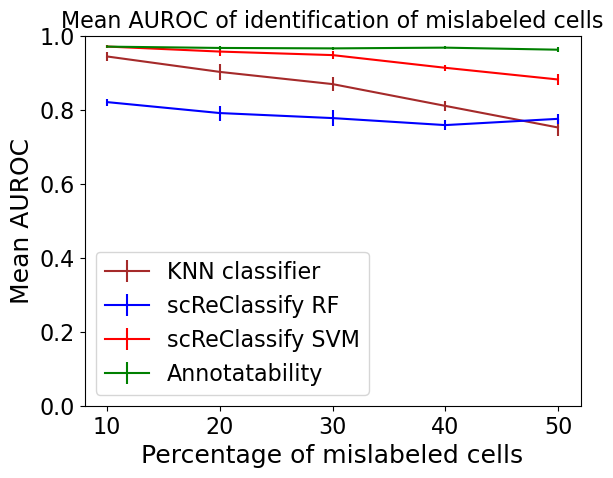

In [42]:
plt.errorbar(np.arange(1,6)*0.1*100, screc_res_list_knn,
             yerr=np.sqrt(np.array(screc_res_list_knn_var)), color='brown',label='KNN classifier')
plt.errorbar(np.arange(1,6)*0.1*100, screc_res_list_rf,
             yerr=np.sqrt(np.array(screc_res_list_rf_var)), color='b',label='scReClassify RF')
plt.errorbar(np.arange(1,6)*0.1*100, screc_res_list_svm,
             yerr=np.sqrt(np.array(screc_res_list_svm_var)), color='r',label='scReClassify SVM')
plt.errorbar(np.arange(1,6)*0.1*100, cell_anno_list,
             yerr=np.sqrt(np.array(cell_anno_list_var)), color='g',label='Annotatability')
plt.ylim([0,1])
plt.title("Mean AUROC of identification of mislabeled cells", fontsize=16)
plt.xlabel("Percentage of mislabeled cells", fontsize=18)
plt.ylabel("Mean AUROC", fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [20]:
screc_res_list_knn

[0.9469841194389625,
 0.8994442094089733,
 0.8558817848971255,
 0.8132466096432157,
 0.7584924873784725]

In [21]:
screc_res_list_rf

[0.8249553794755057,
 0.7791820764873695,
 0.7624617457880134,
 0.7564708856751151,
 0.777861801537608]

In [22]:
screc_res_list_svm

[0.9755716404119038,
 0.9596297617793592,
 0.9379940634619022,
 0.908313286358242,
 0.8841290320942811]

In [22]:
screc_res_list_knn_var

[0.00012526625044564926,
 0.000462695913473533,
 0.00034972410594740855,
 0.0001706351828934316,
 0.0005122215972044486]

In [25]:
print(screc_res_list_knn)
print()
print(screc_res_list_rf)
print()
print(screc_res_list_svm)
print()
print(cell_anno_list)

[0.9469841194389625, 0.8994442094089733, 0.8558817848971255, 0.8132466096432157, 0.7584924873784725]

[0.8249553794755057, 0.7791820764873695, 0.7624617457880134, 0.7564708856751151, 0.777861801537608]

[0.9755716404119038, 0.9596297617793592, 0.9379940634619022, 0.908313286358242, 0.8841290320942811]

[0.9707502935539051, 0.9683849198176425, 0.9692404831281605, 0.9686064093567868, 0.9614855505492906]


In [ ]:
print(screc_res_list_rf_var)
print()
print(screc_res_list_svm_var)
print()
print(cell_anno_list_var)
print()
print(screc_res_list_knn_var)

<ErrorbarContainer object of 3 artists>

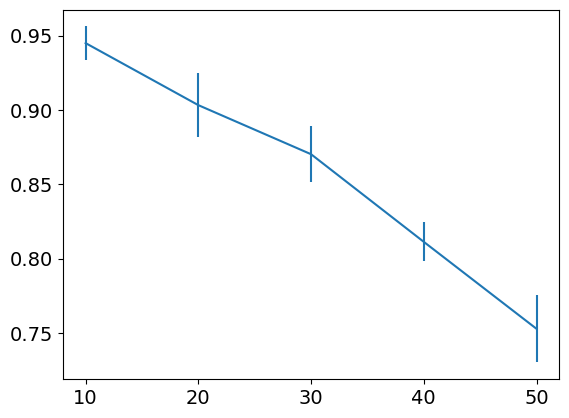

In [34]:
plt.errorbar(np.arange(1,6)*0.1*100, screc_res_list_knn, yerr=np.sqrt(np.array(screc_res_list_knn_var)), label='both limits (default)')
